Install Box2D: `pip install "gymnasium[box2d]"`
To play with the car racing game: `python env/lib/python3.9/site-packages/gymnasium/envs/box2d/car_racing.py`

In continuous space, there are 3 actions:
* 0: steering, -1 is full left, +1 is full right
* 1: gas
* 2: breaking

In discrete space there are 5 actions:
* 0: do nothing
* 1: steer left
* 2: steer right
* 3: gas
* 4: brake

Observation space: a top-down 96x96 RGB image of the car and race track.

The reward is -0.1 every frame and +1000/N for every track tile visited, where N is the total number of tiles visited in the track. For example, if you have finished in 732 frames, the total reward is 1000 - 0.1*732 = 926.8 points.

The episode finishes when all the tiles are visited. The car can also go outside the playfield - that is, far off the track, in which case it will receive -100 reward and die.

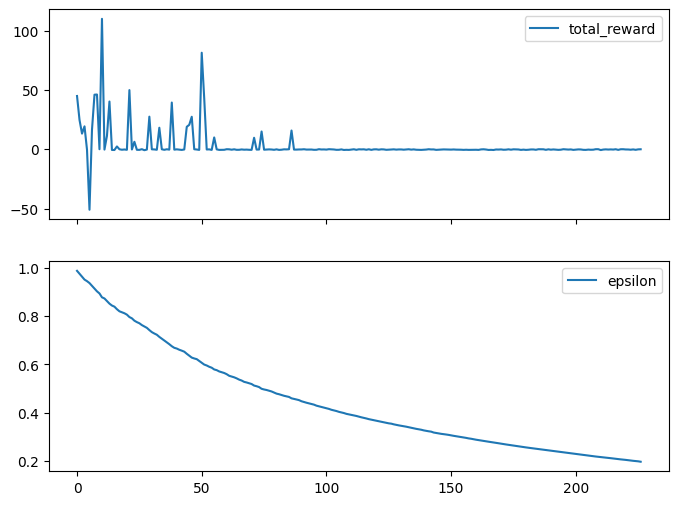

KeyboardInterrupt: 

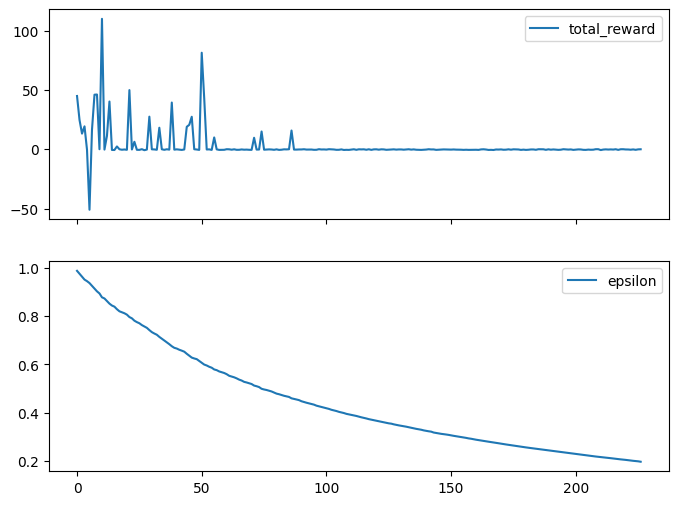

In [1]:
from IPython.display import display, clear_output

import random
import numpy as np
import pickle
from collections import deque
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from torch.utils.tensorboard import SummaryWriter
import gymnasium as gym
import torch

from model import DuelingDQN

# domain_randomize: background and track colours are different on every reset.
env = gym.make("CarRacing-v2", domain_randomize=False, continuous=True)

# state size = 16*16 img *4 frames = 1024 bytes
# 100 MB buffer size = 100 000 states
# buffer has to be large enough to break correlations between multiple states
buffer_size = 5000
buffer = deque(maxlen=buffer_size)  # will automatically pop items when we go over the buffer_size#
buffer_pbar = tqdm(total=buffer_size)  # progress bar to keep track of buffer filling up.

frame_stack_len = 3
skip_frames = 3
epsilon = 1
epsilon_min = 0.1
epsilon_decay = 0.9999 # np.exp(np.log(epsilon_min/epsilon)/60000)  # such that epsilon * epsilon_decay ** 60k steps = epsilon_min

batch_size = 64
gamma = 0.95

model = DuelingDQN(frame_stack_len=3, learning_rate=1e-3)
target_model = DuelingDQN()
tensorboard = False

def sync_models(model, target_model, path="./checkpoints/deep_q_learning/model_sync.pt"):
    torch.save(model.state_dict(), path)
    target_model.load_state_dict(torch.load(path))

sync_models(model, target_model)

if tensorboard:
    writer = SummaryWriter()
else:  # use matplotlib in interactive mode.
    metrics = {
        "total_reward": [],
        "epsilon": [],
    }
    
    plt.ion()  # Turn on interactive mode
    fig, ax = plt.subplots(len(metrics), 1, sharex=True, figsize=(8, 6))
    # Initialize line object and legend

    lines = dict()
    for i, k in enumerate(metrics.keys()):
        lines[k], = ax[i].plot([], [], label=k)
        ax[i].legend(loc="upper right")

# n_episodes = 100
n_updates = 200000
pbar = tqdm(total=n_updates)
updates_counter = 0
episode_counter = 0
best_total_reward = 0
sync_models_frequency = 5  # episodes

while updates_counter < n_updates:
    episode_counter += 1
    # normal reset changes the colour scheme by default
    obs, info = env.reset()
    s = model.preprocess(obs)
    frame_stack = deque(maxlen=frame_stack_len)
    frame_stack.extend([s for _ in range(frame_stack_len)])  # init with the same state.
    done = False
    t = 1
    total_loss = 0
    total_reward = 0
    negative_reward_counter = 0
    time_frame_counter = 1
    while not done:  # sample one episode.
        state = torch.concatenate(list(frame_stack), dim=0)
        state = state.unsqueeze(0)  # add batch dim
        a = model.act(epsilon, state)
        a_arr = model.action_space[a]
        reward = 0
        # repeat same action over skip_frames
        for _ in range(skip_frames):
            t += 1
            new_obs, r, terminated, truncated, info = env.step(a_arr)
            # r = max(-1, r)
            reward += r
            done = terminated or truncated
            if done:
                break
            
        if time_frame_counter > 100 and reward < 0:
            negative_reward_counter += 1
        else:
            negative_reward_counter = 0
        
        # Extra bonus for the model if it uses full gas
        if a_arr[1] == 1 and a_arr[2] == 0:
            reward *= 1.5

        total_reward += reward
        
        new_s = model.preprocess(new_obs)
        frame_stack.append(new_s)

        new_state = torch.concatenate(list(frame_stack), dim=0)
        new_state = new_state.unsqueeze(0)
        
        buffer.append((state, a, reward, new_state, done))
        # only start training once buffer is full
        if len(buffer) < buffer_size:
            buffer_pbar.update(1)
            continue

        time_frame_counter += 1

        # early termination of negative episodes. 
        # This helps training, probably because the agent can play more episodes this way.
        if done or negative_reward_counter >= 25 or total_reward < 0:
            break

        # construct batch.
        batch = {"r": [], "done": [], "s": [], "new_s": [], "a": []}
        for (sj, aj, rj, new_sj, donej) in random.sample(buffer, batch_size):
            batch["done"].append(float(donej))
            batch["r"].append(rj)
            batch["s"].append(sj)
            batch["new_s"].append(new_sj)
            batch["a"].append(aj)

        batch["done"] = torch.tensor(batch["done"])
        batch["r"] = torch.tensor(batch["r"])
        batch["s"] = torch.concatenate(batch["s"], dim=0)
        batch["new_s"] = torch.concatenate(batch["new_s"], dim=0)
        batch["a"] = torch.tensor(batch["a"], dtype=torch.int)

        with torch.no_grad():
            q = target_model.forward(batch["new_s"]).max(dim=-1).values
            batch["y"] = batch["r"] + (1 - batch["done"]) * gamma * q
            batch["y"] = batch["y"].float()

        loss = model.compute_loss(batch["s"], batch["y"], batch["a"])
        total_loss += loss.item()
        loss.backward()
        # model.optimizer.step()
        model.scheduler.step()
        model.optimizer.zero_grad()
        updates_counter += 1
        pbar.update(1)

        epsilon = max(epsilon * epsilon_decay, epsilon_min)

    if updates_counter == 0:
        continue

    if tensorboard:
        writer.add_scalar("Epsilon", epsilon, episode_counter)
        writer.add_scalar('Total Reward per episode', total_reward, episode_counter)
        writer.add_scalar('Episode length', t, episode_counter)
    else:
        metrics["total_reward"].append(total_reward)
        metrics["epsilon"].append(epsilon)
        # Update the data of the line objects
        for key, data in metrics.items():
            lines[key].set_data(range(len(data)), data)
        for i in range(len(ax)):
            ax[i].relim()  # Recalculate limits
            ax[i].autoscale_view(True,True,True)  # Rescale the axis

        clear_output(wait=True)  # Clear the output
        display(fig)  # Re-display the figure

    if total_reward > best_total_reward:
        best_total_reward = total_reward
        torch.save(model.state_dict(), "./checkpoints/best_model.pt")

    if episode_counter % sync_models_frequency == 0:
        sync_models(model, target_model)
    
    if episode_counter % 100 == 0:
        torch.save(model.state_dict(), f"./checkpoints/{episode_counter}.pt")

if tensorboard:
    writer.close()
else:
    plt.ioff()
env.close()



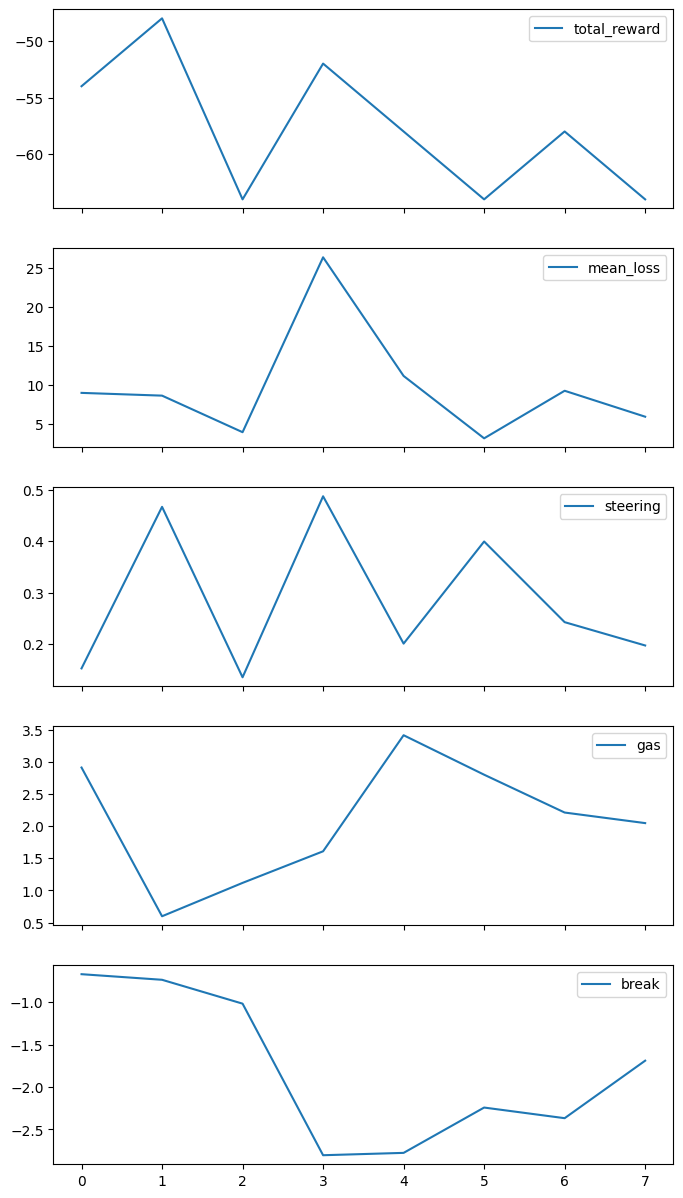

In [15]:
from IPython.display import display, clear_output

import random
import numpy as np
import pickle
from collections import deque
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
# from torch.utils.tensorboard import SummaryWriter
import gymnasium as gym
import torch

from policy_gradient import Policy

# domain_randomize: background and track colours are different on every reset.
env = gym.make("CarRacing-v2", domain_randomize=False, continuous=True)

frame_stack_len = 3
skip_frames = 3

batch_size = 64
gamma = 0.99

model = Policy(frame_stack_len=3, learning_rate=1e-3)
model.load_state_dict(torch.load("./checkpoints/policy_gradient/2000.pt"))
tensorboard = False

if tensorboard:
    writer = SummaryWriter()
else:  # use matplotlib in interactive mode.
    metrics = {
        "total_reward": [], 
        "mean_loss": [], 
        "steering": [],
        "gas": [],
        "break": [],
    }
    
    plt.ion()  # Turn on interactive mode
    fig, ax = plt.subplots(len(metrics), 1, sharex=True, figsize=(8, 3*len(metrics)))
    # Initialize line object and legend

    lines = dict()
    for i, k in enumerate(metrics.keys()):
        lines[k], = ax[i].plot([], [], label=k)
        ax[i].legend(loc="upper right")

# n_episodes = 100
n_updates = 200000
pbar = tqdm(total=n_updates)
updates_counter = 0
episode_counter = 0
best_total_reward = 0

while updates_counter < n_updates:
    episode_counter += 1
    # normal reset changes the colour scheme by default
    obs, info = env.reset()
    s = model.preprocess(obs)
    frame_stack = deque(maxlen=frame_stack_len)
    frame_stack.extend([s for _ in range(frame_stack_len)])  # init with the same state.
    done = False
    t = 1
    total_loss = 0
    total_reward = 0
    negative_consecutive_rewards = 0
    time_frame_counter = 1

    ep_batch = []

    while not done:  # sample one episode.
        state = torch.concatenate(list(frame_stack), dim=0)
        state = state.unsqueeze(0)  # add batch dim
        mean, cov = model.forward(state)
        eps = np.random.normal(0, 1, size=model.n_actions)
        a = mean + torch.sqrt(cov) * torch.tensor(eps, requires_grad=False)
        a = a.flatten()
        a = a.detach().numpy()
        reward = 0
        # repeat same action over skip_frames
        for _ in range(skip_frames):
            t += 1
            new_obs, r, terminated, truncated, info = env.step(a)
            reward += 1 if r > 0 else -1
            done = terminated or truncated
            if done:
                break

        total_reward += reward
        
        if reward < 0:
            negative_consecutive_rewards += 1
        else:
            negative_consecutive_rewards = 0

        if negative_consecutive_rewards > 25:
            break

        new_s = model.preprocess(new_obs)
        frame_stack.append(new_s)

        new_state = torch.concatenate(list(frame_stack), dim=0)
        new_state = new_state.unsqueeze(0)

        time_frame_counter += 1

        # construct batch.
        ep_batch.append(
            (r, a, mean, cov),  # reward, log prob of action with gradient
        )
        pbar.update(1)

    
    # perform gradient descent
    model.optimizer.zero_grad()
    gain = 0
    T = len(ep_batch)
    total_loss = torch.tensor(0.) 
    for i in range(1, T+1):
        r, a, mean, cov = ep_batch[T-i]
        # since we only consider the diagonal of the covariance matrix, we can treat the
        # actions as independent variables.
        a = torch.tensor(a, requires_grad=False)
        log_prob = torch.sum(- (a - mean)**2/(2*cov) - 1/2*torch.log(cov * 2 * torch.pi))
        gain = r + gamma*gain
        loss = - gain * log_prob
        total_loss += loss.sum()

    total_loss.backward()

    # model.scheduler.step()
    model.optimizer.step()

    if tensorboard:
        writer.add_scalar("Mean loss", total_loss.item()/T, episode_counter)
        writer.add_scalar('Total Reward per episode', total_reward, episode_counter)
        writer.add_scalar('Episode length', t, episode_counter)
    else:
        metrics["total_reward"].append(total_reward)
        metrics["mean_loss"].append(total_loss.item()/T)
        metrics["steering"].append(a[0].item())
        metrics["gas"].append(a[1].item())
        metrics["break"].append(a[2].item())
        # Update the data of the line objects
        for key, data in metrics.items():
            lines[key].set_data(range(len(data)), data)
        for i in range(len(ax)):
            ax[i].relim()  # Recalculate limits
            ax[i].autoscale_view(True,True,True)  # Rescale the axis

        clear_output(wait=True)  # Clear the output
        display(fig)  # Re-display the figure

    if total_reward > best_total_reward:
        best_total_reward = total_reward
        torch.save(model.state_dict(), "./checkpoints/policy_gradient/best_model.pt")
    
    if episode_counter % 100 == 0:
        torch.save(model.state_dict(), f"./checkpoints/policy_gradient/{episode_counter}.pt")

if tensorboard:
    writer.close()
else:
    plt.ioff()

env.close()

